In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import datetime

from src.data.get_data import get_url_data

from src.features.df_functions import str_pad, convert_time

# Introduction 
An exploration of reported Chicago Crime data. This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department’s CLEAR (Citizen Law Enforcement Analysis and Reporting) system. 

This report visually explores the data for trends. It also looks for trends using PCA and Gaussian Mixture Models. Through the latter, we see the crime reporting behaves in two distinct patterns: Weekday and Weekend. Weekday crime reporting tends to peak around noon. For Weekends, the flux of crime reports is steady throughout the day. 

However, we do see some weekdays behave like weekends, and conversely, some weekends behave like weekdays. Specifically, there are Tuesdays that behave like weekends, i.e. more crime is reported. Some of those happen to be Christmas, New Years, and July 4th—American holidays. And the two Sundays that behaved like weekdays coincide with playoff games, which might say more about Chicagoans than it's reported crime rates do.   

In summary, more crimes are reported (or perhaps committed?) during hours of leisure. 

# Load data

In [2]:
%%time
data = get_url_data()

...loading csv
CPU times: user 10.7 s, sys: 1.09 s, total: 11.8 s
Wall time: 13.1 s


In [4]:
print('Number of observations: {:,.0f}'.format(len(data)))

Number of observations: 1,827,766


In [29]:
# converts time column to formatted timestamps
data = convert_time(data)

In [31]:
# generate counts for timestamps 
data_time = data['Time Occurred'].groupby(data.index.floor('1min')).agg([ 'count'])
data_time.head()

,count
Date,
2010-01-01 00:01:00,3
2010-01-01 00:02:00,1
2010-01-01 00:05:00,2
2010-01-01 00:10:00,6
2010-01-01 00:15:00,4


# Visually Explore Data

## Monthly crime reports over all collected data 

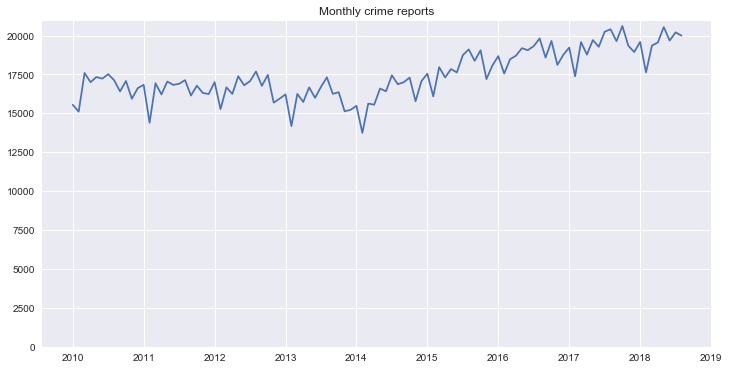

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
title = 'Monthly crime reports'
data_time[data_time.index <=
          '2018-09-01'].resample('M').sum().plot(ax=ax, legend=None, title=title)
plt.ylim(0, None)
plt.xlabel('')

## Crime reports for every day of data as a function of time of day 

In [9]:
pivoted = data_time.pivot_table('count', index=data_time.index.floor('1min').time, columns=data_time.index.date, fill_value=0)
pivoted.head()

,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22
00:01:00,3,8,4,2,5,3,5,3,6,10,...,7,6,10,10,6,13,9,4,6,3
00:02:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:03:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:04:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:05:00,2,2,2,3,2,3,3,2,0,3,...,3,1,4,1,1,2,2,5,5,2


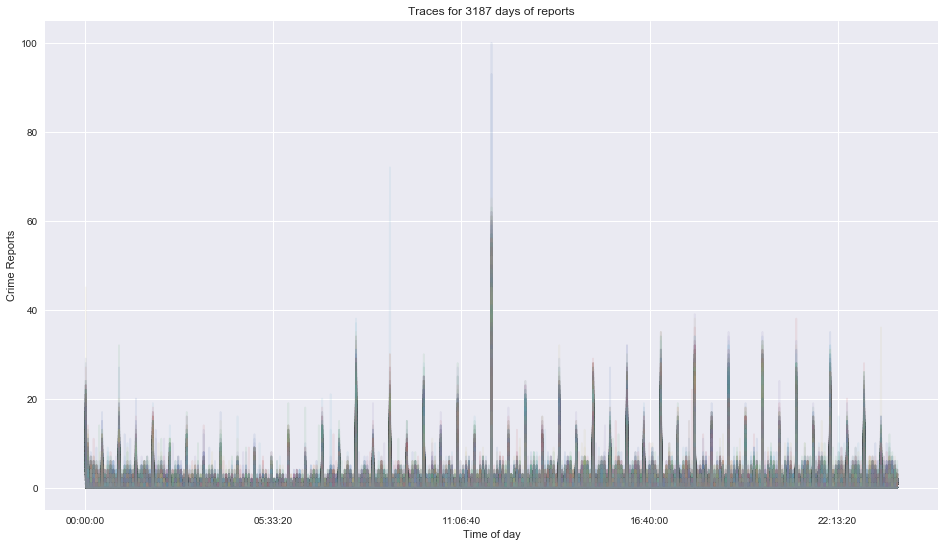

In [34]:
pivoted.plot(legend=False, alpha = 0.1, figsize=(16,9), title = 'Traces for {} days of reports'.format(len(pivoted.columns)));
plt.ylabel('Crime Reports')
plt.xlabel('Time of day')

# Modeling

## PCA analysis 

In [11]:
# create PCA object
pca= PCA()

In [12]:
# observations in rows 

# calculate loading scores and variation each principle compenent acount for 
scaled_data = pivoted.T
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
# generate coordinates based on loading scores and scaled data
pca_data = pca.transform(scaled_data)

In [14]:
# scree plot
# generate percentage that each PCA accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
# generate labels for scree plot
labels = ['PC' + str(num) for num in range(1, len(per_var) + 1)]

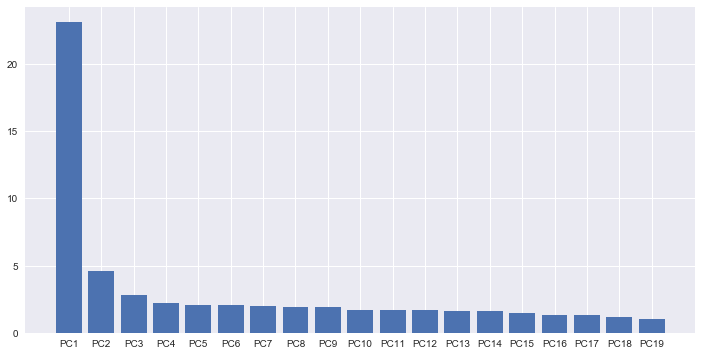

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.bar(left=range(1, 20), height = per_var[0:19], tick_label=labels[0:19])
plt.show()

In [16]:
# generate df with pca coordinates, variables are presented as rows, thus the index should be variable names, the columns represent the different PCA axis 
pca_df = pd.DataFrame(pca_data, index = pivoted.T.index.values,columns=labels)

In [17]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1429,PC1430,PC1431,PC1432,PC1433,PC1434,PC1435,PC1436,PC1437,PC1438
2010-01-01,-47.152188,16.946524,3.404645,0.198449,-4.633534,-1.115146,1.572401,-0.510697,-0.577448,-3.542706,...,0.028720,-0.020969,0.026601,-0.011574,0.005671,-0.019609,-0.009661,-0.005698,0.014349,0.011784
2010-01-02,-35.122274,1.091027,4.436384,4.385195,6.024288,-4.267457,3.185112,2.607650,-2.695581,-2.240907,...,-0.039363,-0.029664,0.016520,-0.027974,-0.015012,-0.006912,0.042668,0.007663,-0.024588,0.012324
2010-01-03,-35.027476,2.779998,-3.652319,2.432474,-0.912626,2.656788,-0.230950,-0.096006,-2.876035,1.910059,...,0.046643,-0.023867,0.023256,-0.048993,0.020619,0.043542,0.002398,0.002390,-0.009306,-0.024460
2010-01-04,-25.848661,-1.949269,1.086502,-1.338002,-2.086197,-1.060601,1.763883,5.046089,-2.654646,-1.901781,...,0.005797,0.025494,-0.014706,-0.080834,0.004578,-0.040916,-0.014588,0.037911,-0.008122,-0.002751
2010-01-05,-17.676446,-3.366142,2.402381,3.131339,0.537546,0.227890,-8.078550,9.418479,-3.550084,0.184492,...,0.019269,0.004990,0.023384,-0.021063,0.013738,0.017831,0.073808,0.010084,0.002871,0.028127


In [18]:
day_of_week = pd.DatetimeIndex(pivoted.columns).dayofweek

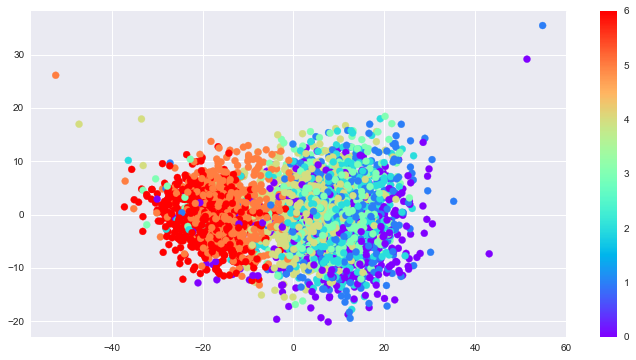

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(pca_df['PC1'],pca_df['PC2'], c = day_of_week, cmap='rainbow');
plt.colorbar();

## Gaussian Mixture Models

In [20]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2)
gmm.fit(scaled_data)
labels = gmm.predict(scaled_data)
labels

array([0, 0, 0, ..., 0, 0, 0])

### Weekday behaviors 

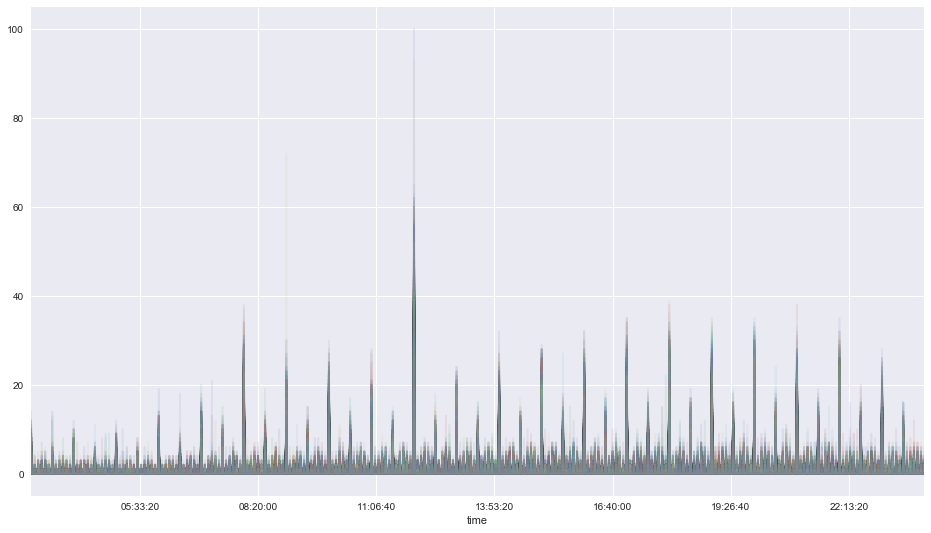

In [21]:
# filters the columns with labels of array of 0s and 1s
pivoted.T[labels==1].T.plot(legend=False, alpha = 0.1,  figsize=(16,9));
plt.xlim(datetime.time(3, 0),datetime.time(23, 59));

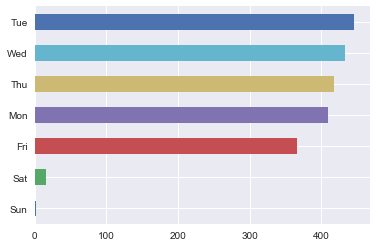

In [22]:
# Isolates weekdays
pd.Series(pd.DatetimeIndex(pivoted.T[labels==1].index).strftime('%a')).value_counts()[::-1].plot(kind='barh');

### Weekend behaviors

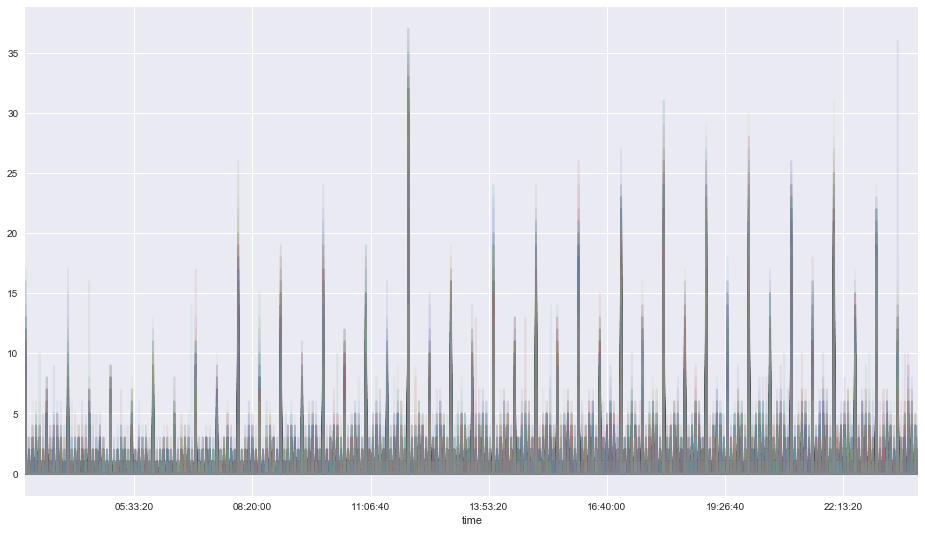

In [23]:
# filters the columns with labels of array of 0s and 1s
pivoted.T[labels==0].T.plot(legend=False, alpha = 0.1,  figsize=(16,9));
plt.xlim(datetime.time(3, 0),datetime.time(23, 59));

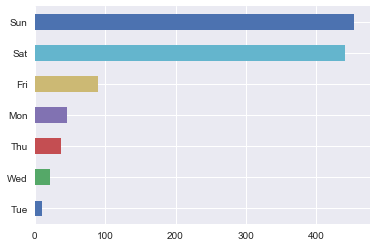

In [24]:
# Isolates weekends
pd.Series(pd.DatetimeIndex(pivoted.T[labels==0].index).strftime('%a')).value_counts()[::-1].plot(kind='barh');

### Some days weekends behave like weekdays, and some weekdays behave like weekends

In [38]:
# Solve for Tue
Tue_index  = pd.DatetimeIndex(pivoted.T[labels==0].index).strftime('%a')=='Tue'

In [39]:
# All Tuesdays that behave like Weekends 
pd.DatetimeIndex(pivoted.T[labels==0].index)[Tue_index]

DatetimeIndex(['2010-01-05', '2010-01-12', '2010-01-19', '2010-03-09',
               '2011-02-22', '2012-12-25', '2013-01-01', '2013-12-24',
               '2017-07-04', '2018-09-18'],
              dtype='datetime64[ns]', freq=None)

In [43]:
# Solve for Sun
Sun_index  = pd.DatetimeIndex(pivoted.T[labels==1].index).strftime('%a')=='Sun'

In [44]:
# All Sundays that behave like Weekdays
pd.DatetimeIndex(pivoted.T[labels==1].index)[Sun_index]

DatetimeIndex(['2017-04-30', '2017-10-22'], dtype='datetime64[ns]', freq=None)